In [2]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.animation as animation
from scipy import stats
from scipy.special import erfc
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain

In [4]:
path = '/home/jonathan/Lab/ATD/codon-tables/data/local_test/N=1e6_b=1_l=2/SC_vs_FF20_0/output/'
with open(path+'2018-04-03_SC_vs_FF20_sim=0_batch=0_favg_traces_N_pop=1e6=T=1000_N=3_b=1_l=2.pickle', 'rb') as handle:
    df = pickle.load(handle)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


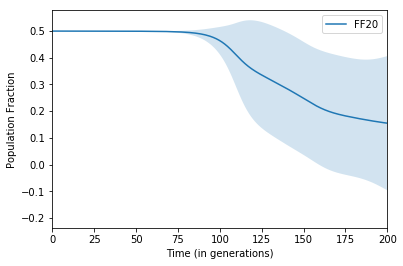

In [38]:
sns.tsplot(data=df, time='time', value='popfrac', unit='sim', condition='code', ci='sd')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.xlim([0,200])
plt.legend()
plt.savefig('test_competition.png')
plt.show()

In [7]:
# unpack some dataframes

DF = pd.DataFrame()
filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_FF16_0/output/2018-04-04_SC_vs_FF16_0_concatenated.pickle', #vs ff16
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_FF20_0/output/2018-04-04_SC_vs_FF20_0_concatenated.pickle', # vs ff20
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_Colorado_0/output/2018-04-04_SC_vs_Colorado_0_concatenated.pickle', # vs colorado
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_RED20_0/output/2018-04-04_SC_vs_RED20_0_concatenated.pickle', # vs red20
    '/home/jonathan/Lab/ATD/codon-tables/data/competition_test/N=1e6_b=1_l=2/SC_vs_PROMISC20_0/output/2018-04-04_SC_vs_PROMISC20_0_concatenated.pickle'
]
# get dataframes
for file in tqdm(filenames, desc='Parsing Dataframes: '):
    with open(file, 'rb') as handle:
        df = pickle.load(handle)
        df = df.loc[(df['sim'] < 10) & (df['code'] != 'Standard Code')]
        DF = pd.concat([DF, df], copy=False)
# with open(filenames[0], 'rb') as handle:
#     df = pickle.load(handle)

HBox(children=(IntProgress(value=0, description='Parsing Dataframes: : ', max=4), HTML(value='')))

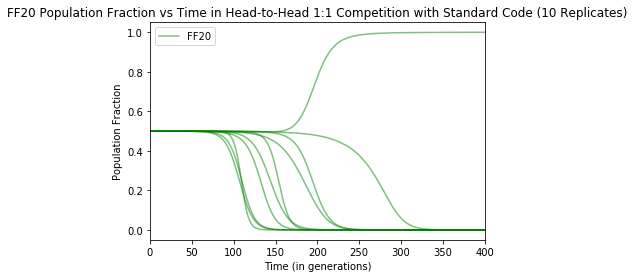

In [39]:
colordict = {
#     'Standard Code' : 'blue',
    'Colorado' : 'red',
    'FF20' : 'green',
    'RED20' : 'purple',
    'PROMISC20' : 'orange'
}
def tracer(code):
    df = DF.loc[DF['code'] == code]
    sims = set(df['sim'])
    for sim in sims:
        lildf = df.loc[df['sim'] == sim]
        t = lildf['time']
        x = lildf['popfrac']
        label = code if sim == 0 else ''
        plt.plot(t, x, color=colordict[code], alpha=0.5, label=label)
tracer('FF20')
plt.xlim([0,400])
plt.title('FF20 Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.legend()
plt.savefig('test_competition_3.png')
plt.show()

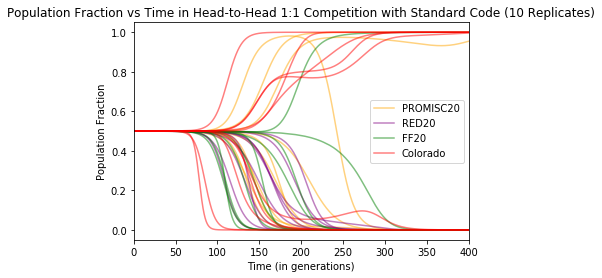

In [37]:
for code in colordict.keys():
    tracer(code)
plt.xlim([0,400])
plt.title('Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


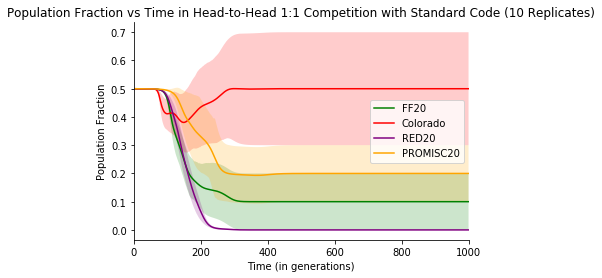

In [9]:
ax1 = sns.tsplot(
    data=DF,
    time='time',
    value='popfrac',
    unit='sim',
    condition='code',
    color=colordict,
    #ci='sd'
)
# format plot
sns.despine()
# plt.xlim([0, 1000])
# plt.ylim([0, 1.3])
plt.legend()
plt.title('Population Fraction vs Time in Head-to-Head 1:1 Competition with Standard Code (10 Replicates)')
plt.xlabel('Time (in generations)')
plt.ylabel('Population Fraction')
plt.savefig('test_competition_2.png')
plt.show()

HBox(children=(IntProgress(value=0, description='Processing sims: : ', max=10001), HTML(value='')))

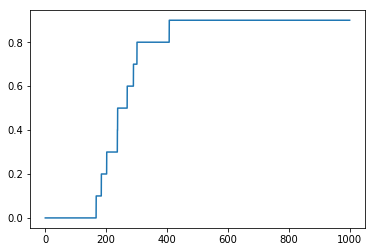

In [54]:
# lets make one contour line
t = df.loc[df['sim'] == 0]['time']
contain_probability = np.zeros(len(t))
num_sims = len(set(df['sim']))
for ind in tqdm(range(len(contain_probability)), desc='Processing sims: '):
    lildf = df.loc[ind]
    contain_probability[ind] = sum(lildf['popfrac'] == 0) / num_sims
plt.plot(t, contain_probability)

In [53]:
num_sims

10

3441/|/  3%|| 3441/100010 [00:30<14:03, 114.55it/s]